# Otimização Bayesiana

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Introdução
- 2) Otimização bayesiana
- 3) Visualizando a Otimização bayesiana

__________

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

    # ============================================

    f1_score_weighted = f1_score(y_test, y_pred_test, average='weighted')
    print(f"F1-score weighted: {100*f1_score_weighted:.2f}")
    return f1_score_weighted

____
____
_____

## 1) Introdução

Desde que conhecemos os primeiros estimadores utilizados para a construção de modelos, uma preocupação adicional nos acompanhou: o ajuste de valores dos hiperparâmetros.

Quase todos os estimadores que conhecemos têm um ou mais **hiperparâmetros** associados.

Como vimos, os hiperparâmetros influenciam o comportamento do modelo (e, portanto, são muito importantes), mas eles não são determinados a partir dos dados! É nosso dever, como cientistas de dados, fornecer valores adequados para os hiperparâmetros.

No começo de nossa jornada, nós utilizávamos os valores default para os hiperparâmetros, ou então, mudávamos manualmente alguns valores, para sensibilizar a influência dos hiperparâmetros no modelo final.

Mas logo percebemos que essa não era a melhor abordagem --- precisávamos de um método mais sistemático para a busca de bons valores para os hiperparâmetros!

_______

Para este fim, introduzimos inicialmente o **grid search**, que **testa exaustivamente** combinações explícitas de valores de hiperparâmetros.

Apesar de simples e direta, esta é uma abordagem computacionalmente muito custosa (sentimos isso na pele, ao rodar rotinas de grid search que demoram horas, ou até mesmo dias!). 

De fato, esta é uma abordagem de força bruta que, aliás, não nos dá garantia nenhuma: é perfeitamente possível que nenhuma das combinações que estabelecemos seja boa boa! Oras, há muitos casos em que o **espaço de hiperparâmetros** é infinito (basta considerar um hiperparâmetro dado por um float que não é limitado).

______

Para endereçar este problema, introduzimos então o **random search**.

Neste caso, ao invés de disponibilizarmos valores específicos de hiperparâmetros a serem combinados, disponibilizamos **intervalos** ou explicitamente **distribuições de probabilidade** sobre o espaço de parâmetros de cada hiperparâmetro, e **amostramos valores aleatórios** destas distribuições para gerar as combinações.

Com essa abordagem estocástica, há a possibilidade de encontrarmos boas combinações, que não estariam inclusas nos valores explícitos que passamos para o grid search.

Por outro lado, com o random search também não temos garantia alguma que as melhores combinações serão encontradas, sobretudo porque **todas as combinações são amostradas de maneira aleatória**. Ou seja, todas as combinações são amostradas **sem considerar** a performance das combinações anteriores. Com esta metodologia, fica difícil garantirmos que efetivamente encontraremos boas combinações...

Metodologia de grid search (à esquerda) vs random search (à direita):

<img src=https://www.researchgate.net/profile/Minrui-Zheng/publication/328252103/figure/fig4/AS:766093471801344@1559662325592/Distribution-of-sampled-hyperparameters-a-grid-search-b-random-search.png width=600>

Gridsearch

<img src="https://inotgo.com/imagesLocal/202112/07/20211207175525489M_4.gif" width=400 text="https://chowdera.com/2022/01/202201031814095745.html">

Randomsearch

<img src="https://inotgo.com/imagesLocal/202110/20/20211020234558679h_3.gif" width=400 text="https://chowdera.com/2022/01/202201031814095745.html"> 

O que queremos:

<img src="https://inotgo.com/imagesLocal/202112/07/20211207175525489M_0.gif" width=400 text="https://chowdera.com/2022/01/202201031814095745.html"> 

_________

Então, podemos nos perguntar: qual seria o próximo passo? Existiria um método ainda mais eficiente e "educado" para fazer a otimização de hiperparâmetros?

A resposta é: sim! Hoje, conheceremos o método de **otimização Bayesiana**, aplicada à otimização de hiperparâmetros!

E a principal motivação de utilização é em uma condição em que é muito custoso (financeiramente ou em tempo) rodar os testes de parâmetros várias vezes. Em alguns casos, rodar o modelo uma única vez para apenas um conjunto de parâmetros pode demorar horas e, dessa forma, é inviável realizarmos uma busca de parâmetros com grid ou random search.

_________
_________
_________

## 2) Otimização Bayesiana

O objetivo da otimização baeysiana é o mesmo que tínhamos com o grid e random search: **determinar os valores adequados para um conjunto de hiperparâmetros**, de modo que a combinação de valores **proporcione os melhores valores para uma métrica de avaliação calculada em dados de validação**.

O que muda com a otimização baeysiana é a forma como isso será feito.

Já descrevemos os problemas que ambos grid e random search têm. Sobretudo, o fato das combinações de valores dos hiperparâmetros serem independentes entre si, sem levar em consideração combinações anteriores, que poderiam ser boas.

>Pra entender isso melhor, imagine o cenário em que queremos otimizar 3 hiperparâmetros.
<br><br>
>Pode ser que, em uma combinação, encontremos bons valores para 2 dos 3 hiperparâmetros; ja, na próxima, como os 3 valores serão novos, pode ser que os 3 sejam ruins. Não seria interessante de conseguíssemos manter a informação sobre os valores bons que encontramos?

Esse é o espírito da otimização baeysiana!

Pra entender isso intuitivamente, considere a figura a seguir (suponha que o "score" é um erro, então, quanto menor, melhor):

<img src=https://miro.medium.com/max/1120/1*MiNXGrkk5BbjfkNAXZQSNA.png width=400>

Pergunta: onde você concentraria a busca por valores do hiperparâmetro `n_estimators`?

Olhando pro gráfico, existe claramente uma região no espaço do hiperparâmetro `n_estimators` que é melhor: menos de 200 árvores.

**Uma vez que temos este conhecimento**, realmente não faz sentido algum que os próximos valores que vamos testar sejam maiores que 200, não é mesmo?

Esse é o espírito da otimização bayesiana: **utilizamos a informação que temos quanto ao score alcançado com valores iniciais de hiperparâmetros para guiar a escolha dos próximos valores!**

E aqui já fica claro o porquê do método receber o título "bayesiano": de fato, estamos nos utilizando da "filosofia" bayesiana de ajuste de estratégia conforme agregamos novas informações! 

>E é por isso que a otimização bayesiana é tão mais eficiente que as estratégias anteriores: gastamos um pouco mais de energia para propor combinações de hiperparâmetros **levando em consideração** as combinações passadas e suas respectivas perfomances.
<br><br>
Com isso, podemos focar apenas em testar **combinações promissoras**, e não precisamos gastar energia em procurar por combinações que sabemos não ser tão boas.

Faz sentido, não é mesmo?

Agora, precisamos apenas entender **como** é possível implementar isso.

### 2.1) Função objetivo

É razoável assumirmos que existe uma função que relaciona a métrica de performance (score) que temos interesse de otimizar e os hiperparâmetros, não é mesmo?

Sabendo que as métricas de performance essencialmente comparam os targets preditos com os targets reais, e sabendo que os targets preditos (pela hipótese) são influenciados pelos hiperparâmetros, é bem natural que assumamos que esta função existe.

<img src="surrogate_function.png" width=600>

Agora, o ponto é que pode ser extremamente difícil escrever esta função explicitamente. Como nosso objetivo será encontrar valores que **otimizam** a função, costumamos chamá-la de **função objetivo**. 

Mas, veja, queremos otimizar uma função objetivo **sem nem saber qual é sua dependência funcional com os hiperparâmetros**. Problemas deste tipo são chamados de **otimização de caixa-preta**, e existem várias técnicas para abordá-los. Recomendo [este material](https://www.lix.polytechnique.fr/~dambrosio/blackbox_material/Cassioli_1.pdf) aos interessados.

Quando formos pra prática, construiremos a função objetivo implicitamente, como o resultado retornado por uma **métrica de avaliação** dado o treinamento de um modelo. 

Na prática, isso nos será suficiente, pois bastará que tomemos **alguns pontos** desta função, para seguir com sua otimização, isso graças à introdução do surrogate model.

<img src=https://www.researchgate.net/profile/Abraham-Duarte/publication/236164556/figure/fig1/AS:393408515461120@1470807307227/Schematic-representation-of-the-black-box-optimization-framework.png width=500>

### 2.2) Surrogate model

Na prática, iremos apenas **avaliar alguns pontos da função objetivo** e construir um **modelo probabilístico dela** com base nestes pontos, que serão tratados como **amostras**.

Nós vamos aproximar o black box utilizando um modelo probabilístico e os dados de treino que temos. Tendo esse modelo probabilístico podemos inferir quais são os melhores parâmetros sem ter que toda hora testá-los no modelo

Este modelo probabílistico é conhecido como **surrogate model (modelo substituto ou emulador)**, pois ele emula probabilisticamente o que seria a função real sem a necessidade dela ser reconstruída explicitamente. E o melhor, dado que o modelo surrogate é bem mais simples que a função objetivo, será muito mais fácil otimizá-lo do que a função objetivo em si!

<img src=https://miro.medium.com/max/1400/1*01OV9s_DYaK8k-cwa0bk3A.png width=600 text='https://towardsdatascience.com/the-beauty-of-bayesian-optimization-explained-in-simple-terms-81f3ee13b10f'>

Suponha que temos 8 pontos que foram obtidos ao passarmos 8 valores distintos de max_depth pro nosso modelo e que queremos minimizar nossa métrica de avaliação, como o MSE. Esses pontos obtidos pertencem à uma função objetivo desconhecida, mas que será emulada pela surrogate function. Sabendo quem são os pontos atuais de mínimo, podemos escolher outros pontos próximos à estes para serem testados no modelo de ML. Com isso, podemos atualizar nosso surrogate model nessas áreas de maior interesse. Depois de uma certa quantidade de iterações, devemos chegar bem próximos do mínimo global.

<img src=https://miro.medium.com/max/1400/1*31TpvO5XO_VGaZG0m3FgVg.png width=600 text='https://towardsdatascience.com/the-beauty-of-bayesian-optimization-explained-in-simple-terms-81f3ee13b10f'>


Assim vemos que o surrogate model acompanha os resultados de avaliações anteriores para formar um modelo probabilístico de mapeamento de hiperparâmetros para uma probabilidade de uma pontuação na função objetivo:

O ponto é que nosso modelo surrogate será atualizado **de maneira bayesiana**, isto é, levando em consideração scores anteriores (à priori) para sugerir as próximas combinações (à posteriori) de hiperparâmetros:

$$P(score|hiperparâmetros)$$

Esse modelo substituto é muito mais fácil de otimizar do que a função objetivo.

Operacionalmente, para essa primeira parte seguiremos o seguinte passo-a-passo:

- Escolhemos alguns pontos aleatoriamente;
- Construiremos um modelo probabilístico surrogate para a função objetivo;
- Otimizaremos o modelo surrogate, encontrando bons valores para os hiperparâmetros nesta função;
- Utilizamos estes valores encontrados e damos de input para a função objetivo real, e amostramos um novo ponto;
- Atualizamos o modelo surrogate, incorporando o novo ponto amostrado;
- Repetimos os últimos 3 passos, até atingirmos o critério de parada (em geral, um número pré-definido de passos).


Contudo, há muitas formas possíveis para modelarmos a função surrogate e suas incertezas. Um método muito interessante é o que utiliza **processos gaussianos**. Sugiro muito a leitura [deste post interativo](https://distill.pub/2019/visual-exploration-gaussian-processes/) para conhecer um pouco mais sobre este método; e [este post](https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0) para uma intuição quanto a sua aplicação como modelo surrogate da otimização bayesiana.

Uma analogia com esses processos gaussianos pode ser pensada com jogar um dado que ao invés de retornar um número de 1 à 6, retorna uma função diferente que pode ser ajustada nos pontos disponibilizados. Usamos a média desse processo gaussiano como a função que mais aproxima a função caixa preta e sua variação para construir uma área de incertezas da nossa função objetivo (área em cinza). Link para entender como funcionam os [processos gaussianos](https://towardsdatascience.com/an-intuitive-guide-to-gaussian-processes-ec2f0b45c71d).

<img src=https://miro.medium.com/max/1400/0*09NmB3U7dZ8bvU81.png width=700 text='https://towardsdatascience.com/the-beauty-of-bayesian-optimization-explained-in-simple-terms-81f3ee13b10f'>

Mas ainda resta uma pergunta: qual é exatamente este critério de escolha das regiões? **Como**, a cada iteração, os próximos valores de hiperparâmetros são propostos, com o objetivo de minimizar a função objetivo?

Isto é feito de acordo com a chamada **função de seleção**.

### 2.3) Função de seleção/aquisição (acquisition function)

O objetivo da função de seleção é muito simples: **determinar os valores dos hiperparâmetros que são escolhidos do modelo surrogate** a cada passo.

Há vários critérios possíveis, mas o mais comum é conhecido como **Expected Improvement** (melhoria esperada). Seu uso é bem direto: **propomos novos valores de hiperparâmetros de modo que o expected improvement seja maximizado**. 

Podemos omitir aqui os detalhes matemáticos, o importante é lembrarmos que o papel da função de seleção é estabelecer o critério segundo o qual o modelo surrogate irá proporcionar os valores de hiperparâmetros a cada iteração.

E, com isso, conseguimos, a cada iteração, propor candidatos a valores de hiperparâmetros que melhoram o modelo surrogate. O registro destes valores é muito importante, para que o teorema de Bayes entre em ação!

<img src=https://www.researchgate.net/publication/358344674/figure/fig2/AS:1119596249645056@1643943955386/Two-exemplary-iterations-of-a-Bayesian-Optimization-BO-on-a-1D-function-The-BO.png width=600 text='www.researchgate.net/publication/358344674_Review_of_automated_time_series_forecasting_pipelines'>

Vamos ver como isso funciona iterativamente:

<img src=https://miro.medium.com/max/1400/1*YVkGpTThrtnsNCeBjRr1lw.gif width=700 text="https://medium.com/@gerbentempelman/comparing-hyperparameter-optimization-frameworks-in-python-a-conceptual-and-pragmatic-approach-24d9baa1cc69">

A linha f em azul representa a função objetivo desconhecida. Ela é iterativamente aproximada pelo modelo substituto criado por um processo gaussiano (GP) o qual é representado pela linha laranja (+ intervalos de confiança). À medida que o número de iterações aumenta, melhor o modelo é capaz de determinar onde f é minimizado. A função de aquisição (EI - Expected Impute) indica onde no espaço de busca o modelo substituto deve se orientar, e para isso ele procura maximizar o EI.

### 2.4) Histórico de registros

O histórico de registros, que é uma tupla com **(valores de hiperparâmetros, respectivo score)** é muitíssimo importante para que seja possível a construção de um modelo surrogate que, a cada passo, melhora a descrição probabilística da função objetivo.

Isso é importante pois, quão melhor for nossa descrição da função objetivo, teremos que o passo disponibilizado pelo expected improvement irá proporcionar hiperparâmetros mais próximos do ótimo da função objetivo. 

E é aqui que o teorema de Bayes entra em ação: a partir de novas evidências (amostras do surrogate), atualizamos a nossa descrição da função objetivo com cada vez mais detalhes, e, assim, ela fica mais fácil de ser otimizada sem precisar ser explicitamente construída!

<img src=https://miro.medium.com/max/1400/1*RQ-pAwQ88yC904QppChGPQ.png width=500>

<img src=https://miro.medium.com/max/1400/1*bSLAe1LCj3mMKfaZsQWCrw.png width=500>

__________

#### Retomando alguns conceitos:
- **Otimização Bayesiana** é uma abordagem que utiliza o Teorema de Bayes para direcionar a busca a fim de encontrar o mínimo ou o máximo de uma função objetivo. No nosso caso a probabilidade posterior é uma função objetiva substituta (surrogate objective model).

$$  P(A|B) = \frac{P(B|A) * P(A)}{P(B)} $$

Aqui removemos o valor normalizador de $P(B)$ do Teorema de Bayes e descrevemos a probabilidade condicional como uma quantidade proporcional. Isso é útil, pois não estamos interessados ​​em calcular uma probabilidade condicional específica, mas em otimizar uma quantidade.

$$  P(A|B) = P(B|A) * P(A) $$

A probabilidade condicional que estamos calculando é geralmente chamada de probabilidade posterior; a probabilidade condicional reversa às vezes é chamada de probabilidade e a probabilidade marginal é chamada de probabilidade anterior; e por isso podemos escrever:

$$ posterior = likelihood * prior $$

Isso fornece uma estrutura que pode ser usada para quantificar as crenças sobre uma função objetivo desconhecida dadas amostras do domínio e sua avaliação por meio da função objetivo. [link](https://machinelearningmastery.com/what-is-bayesian-optimization/)

- **Função objetivo:** É a função que recebe um conjunto de hiperparâmetros e retorna uma métrica escalar que precisa ser minimizada ou maximizada. No nosso caso ela é desconhecida.
- **Espaço de busca:** São os limites mínimo e máximo para cada hiperparâmetro que será avaliado.
- **Surrogate model:** Modelo probabilístico utilizado para aproximar a função objetivo.
- **Processos Gaussianos:** É o método que cria o surrogate model. Ele e o método Tree-Parzen Estimators são os mais comuns de serem utilizados, mas algumas bibliotecas também usam Random Forests e o Gradient Boosting. 
- **Função de seleção/aquisição:** É técnica que irá definir qual o próximo conjunto de hiperparâmetros a ser testado. Ou seja, passaremos esses hiperparâmetros para o modelo de ML e salvaremos o score resultante.
- **Expected Improvement:** É uma das formas de se fazer a função de seleção. O pensamento central para toda essa abordagem é que a extensão em que a função substituta é capaz de aproximar a função objetivo é assumida como dependente de quantas iterações o método pode fazer. Em palavras simples: presume-se que o desempenho aumenta à medida que o número de iterações aumenta.

#### Passo-a-passo
Agora que já conhecemos todos os ingredientes importantes, podemos enunciar o passo-a-passo da otimização bayesiana:

- Primeiro definimos um espaço de busca para cada um dos hiperparâmetros;
- Escolhemos alguns pontos desse espaço aleatoriamente;
- Avaliamos esses pontos implicitamente com a função objetivo, que tem como inputs os hiperparâmetros, e como output o score a ser otimizado (que será a métrica de avaliação de interesse);
- Utilizamos esses pontos como priori para construir o modelo surrogate probabilístico da função objetivo através de um processo gaussiano;
- Em um loop:
    - A otimização da função de seleção irá determinar os próximos valores para os hiperparâmetros a serem escolhidos - reavalia esses pontos no modelo de ML
    - Atualizamos o histórico de valores de hiperparâmetros e respectivo score, que é utilizado pelo algoritmo para a atualização do modelo surrogate;
    - Repetimos o processo até o critério de parada.

E é isso!

Para os interessados em maiores detalhes matemáticos, recomendo fortemente [este artigo](http://proceedings.mlr.press/v28/bergstra13.pdf), e [este também](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf), que reporta resultados incríveis a favor do uso de otimização bayesiana como alternativa aos métodos tradicionais de otimização de hiperparâmetros.

Agora, vamos ver o método funcionando na prática!

______________

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

def pipe_pre_process_german(drop_not_features=["Risk"], col_target="Risk",
                             inputer_num_strategy="mean",
                             encoding="ordinal"):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''
    
    df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

    X = df.drop(columns=drop_not_features)
    y = df[col_target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist() #lista de colunas paa aplicar

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

Vamos construir um modelo com os hiperparâmetros default (mas `learning_rate=0.1`)

In [4]:
X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process_german(drop_not_features=["Risk"], 
                                                                            col_target="Risk",
                                                                            inputer_num_strategy="mean",
                                                                            encoding="ordinal")

In [5]:
pre_processador

ColumnTransformer(transformers=[('transf_num',
                                 Pipeline(steps=[('input_num', SimpleImputer()),
                                                 ('std', StandardScaler())]),
                                 ['Age', 'Job', 'Credit amount', 'Duration']),
                                ('transf_cat',
                                 Pipeline(steps=[('input_cat',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Sex', 'Housing', 'Saving accounts',
                                  'Checking account', 'Purpose'])])

In [6]:
from sklearn.ensemble import GradientBoostingClassifier


Métricas de avaliação de treino:


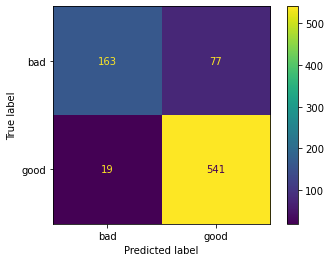

              precision    recall  f1-score   support

         bad       0.90      0.68      0.77       240
        good       0.88      0.97      0.92       560

    accuracy                           0.88       800
   macro avg       0.89      0.82      0.85       800
weighted avg       0.88      0.88      0.87       800


Métricas de avaliação de teste:


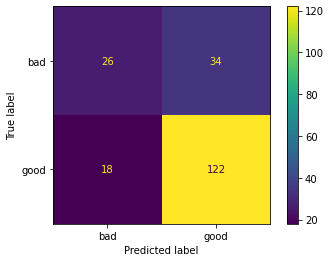

              precision    recall  f1-score   support

         bad       0.59      0.43      0.50        60
        good       0.78      0.87      0.82       140

    accuracy                           0.74       200
   macro avg       0.69      0.65      0.66       200
weighted avg       0.72      0.74      0.73       200

F1-score weighted: 72.70


In [7]:
pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

pipe.fit(X_train, y_train)

score = metricas_classificacao(pipe, X_train, X_test, y_train, y_test)

Nada mal. Vamos ver se conseguimos melhorar com o Grid Search:

In [8]:
pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

params_grid = {"gb__loss" : ["deviance", "exponential"],
               "gb__n_estimators" : [5, 25, 50],
               "gb__max_depth" : [5, 10, 15]}

splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

grid_gb = GridSearchCV(pipe,
                       params_grid, 
                       cv=splitter,
                       scoring="f1_weighted",
                       n_jobs=-1)

grid_gb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                          

In [9]:
grid_gb.best_params_

{'gb__loss': 'deviance', 'gb__max_depth': 5, 'gb__n_estimators': 50}


Métricas de avaliação de treino:


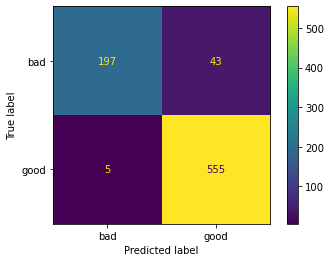

              precision    recall  f1-score   support

         bad       0.98      0.82      0.89       240
        good       0.93      0.99      0.96       560

    accuracy                           0.94       800
   macro avg       0.95      0.91      0.92       800
weighted avg       0.94      0.94      0.94       800


Métricas de avaliação de teste:


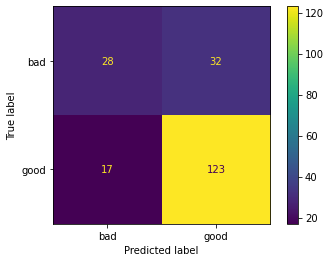

              precision    recall  f1-score   support

         bad       0.62      0.47      0.53        60
        good       0.79      0.88      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200

F1-score weighted: 74.37


In [10]:
score_grid = metricas_classificacao(grid_gb, X_train, X_test, y_train, y_test)

In [11]:
print(f"Score sem search: {100*score:.2f}\nScore com grid: {100*score_grid:.2f}")

Score sem search: 72.70
Score com grid: 74.37


Resultado legal, melhoramos um pouco o f1 weighted.

Mas será que não dá pra melhorar ainda mais? Vamos pra otimização Bayesiana!

#### [BayesSearchCV](http://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV)

Para utilizar essa biblioteca é necessário intalar o pacote scikit-optimize

In [12]:
# !pip install scikit-optimize
# conda install -c conda-forge scikit-optimize

In [15]:
print(pd.__version__)

1.4.2


In [16]:
import sklearn
print(sklearn.__version__)

1.0.2


In [17]:
from skopt import BayesSearchCV

params_grid = {"gb__loss" : ["deviance", "exponential"],  # categorical parameter
               "gb__n_estimators" : (10, 100, 'uniform'),
               "gb__max_depth" : (1, 50, 'uniform')
               }

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    pipe,
    params_grid,
    scoring="f1_weighted",
    n_iter=50,
    cv=splitter,
    random_state=42,
    verbose=2
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=deviance, gb__max_depth=37, gb__n_estimators=94; total time=   0.9s
[CV] END gb__loss=deviance, gb__max_depth=37, gb__n_estimators=94; total time=   0.9s
[CV] END gb__loss=deviance, gb__max_depth=37, gb__n_estimators=94; total time=   0.7s
[CV] END gb__loss=deviance, gb__max_depth=37, gb__n_estimators=94; total time=   0.8s
[CV] END gb__loss=deviance, gb__max_depth=37, gb__n_estimators=94; total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=44, gb__n_estimators=37; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=44, gb__n_estimators=37; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=44, gb__n_estimators=37; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=44, gb__n_estimators=37; total time=   0.4s
[CV] END gb__loss=exponential, gb__max_depth=44, gb__n_estimators=37; total time=   0.4s
Fitting

[CV] END gb__loss=deviance, gb__max_depth=6, gb__n_estimators=100; total time=   0.4s
[CV] END gb__loss=deviance, gb__max_depth=6, gb__n_estimators=100; total time=   0.3s
[CV] END gb__loss=deviance, gb__max_depth=6, gb__n_estimators=100; total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=deviance, gb__max_depth=17, gb__n_estimators=76; total time=   0.9s
[CV] END gb__loss=deviance, gb__max_depth=17, gb__n_estimators=76; total time=   0.7s
[CV] END gb__loss=deviance, gb__max_depth=17, gb__n_estimators=76; total time=   0.7s
[CV] END gb__loss=deviance, gb__max_depth=17, gb__n_estimators=76; total time=   0.7s
[CV] END gb__loss=deviance, gb__max_depth=17, gb__n_estimators=76; total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=deviance, gb__max_depth=1, gb__n_estimators=56; total time=   0.0s
[CV] END gb__loss=deviance, gb__max_depth=1, gb__n_estimators=56; total time=   0.0s
[CV] END gb__loss=devian

C:\Users\RMM\anaconda3\envs\turma815\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=deviance, gb__max_depth=11, gb__n_estimators=100; total time=   1.3s
[CV] END gb__loss=deviance, gb__max_depth=11, gb__n_estimators=100; total time=   1.2s
[CV] END gb__loss=deviance, gb__max_depth=11, gb__n_estimators=100; total time=   1.3s
[CV] END gb__loss=deviance, gb__max_depth=11, gb__n_estimators=100; total time=   1.4s
[CV] END gb__loss=deviance, gb__max_depth=11, gb__n_estimators=100; total time=   1.1s


C:\Users\RMM\anaconda3\envs\turma815\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.5s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=28, gb__n_estimators=10; total time=   0.0s
[CV] END gb__loss=exponential, gb__max_depth=28, gb__n_estimators=10; total time=   0.0s
[CV] END gb__loss=exponential, gb__max_depth=28, gb__n_estimators=10; total time=   0.0s
[CV] END gb__loss=exponential, gb__max_depth=28, gb__n_estimators=10; total time=   0.1s
[CV] END gb__loss=exponential, gb__max_depth=28, gb__n_estimators=10; total time=

C:\Users\RMM\anaconda3\envs\turma815\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=6, gb__n_estimators=55; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=6, gb__n_estimators=55; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=6, gb__n_estimators=55; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=6, gb__n_estimators=55; total time=   0.1s
[CV] END gb__loss=exponential, gb__max_depth=6, gb__n_estimators=55; total time=   0.

C:\Users\RMM\anaconda3\envs\turma815\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.4s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=31, gb__n_estimators=100; total time=   0.8s
[CV] END gb__loss=exponential, gb__max_depth=31, gb__n_estimators=100; total time=   0.9s
[CV] END gb__loss=exponential, gb__max_depth=31, gb__n_estimators=100; total time=   0.9s
[CV] END gb__loss=exponential, gb__max_depth=31, gb__n_estimators=100; total time=   0.8s
[CV] END gb__loss=exponential, gb__max_depth=31, gb__n_estimators=100; total 

C:\Users\RMM\anaconda3\envs\turma815\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s


C:\Users\RMM\anaconda3\envs\turma815\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s


C:\Users\RMM\anaconda3\envs\turma815\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.3s


C:\Users\RMM\anaconda3\envs\turma815\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
[CV] END gb__loss=exponential, gb__max_depth=5, gb__n_estimators=100; total time=   0.2s
val. score: 0.7357567162240468
test score: 0.7515981735159818
best params: OrderedDict([('gb__loss', 'exponential'), ('gb__max_depth', 5), ('gb__n_estimators', 100)])



Métricas de avaliação de treino:


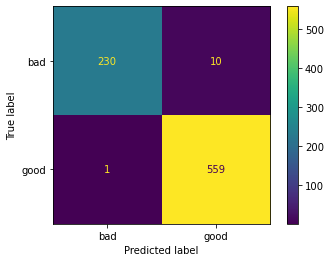

              precision    recall  f1-score   support

         bad       1.00      0.96      0.98       240
        good       0.98      1.00      0.99       560

    accuracy                           0.99       800
   macro avg       0.99      0.98      0.98       800
weighted avg       0.99      0.99      0.99       800


Métricas de avaliação de teste:


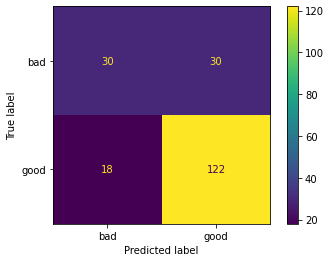

              precision    recall  f1-score   support

         bad       0.62      0.50      0.56        60
        good       0.80      0.87      0.84       140

    accuracy                           0.76       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.75      0.76      0.75       200

F1-score weighted: 75.16


In [18]:
score_opt = metricas_classificacao(opt, X_train, X_test, y_train, y_test)

In [20]:
print(f"Score sem search: {100*score:.2f}\nScore com grid: {100*score_grid:.2f}\nScore com bays: {100*score_opt:.2f}")

Score sem search: 72.70
Score com grid: 74.37
Score com bays: 75.16


#### Gráfico de convergência ([convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence))
Com o método `plot_convergence` podemos ver como está a convergência da nossa análise de hiperparâmetros.


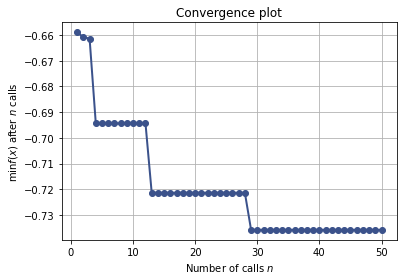

In [21]:
from skopt.plots import plot_convergence

plot_convergence(opt.optimizer_results_[0]);

#### Gráficos de Dependência Parcial ([Partial Dependence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective))

O que é: o gráfico de dependência parcial mostra o efeito marginal que uma ou duas features têm no resultado previsto de um modelo, marginalizando os valores das demais features de entrada.

O método `plot_objective()` plota uma matriz 2-d com os chamados gráficos de dependência parcial da função objetivo, ou seja, mostra a influência de cada dimensão do espaço de busca na função objetivo. Para estimar a função objetivo ele usa o último modelo ajustado.

Na diagonal temos o efeito de uma única dimensão na função objetivo, enquanto os gráficos abaixo da diagonal mostram o efeito na função objetivo ao variar duas dimensões.

A Dependência Parcial é calculada pela média do valor objetivo para um número de amostras aleatórias no espaço de busca, mantendo uma ou duas dimensões fixas em intervalos regulares. Isso calcula a média do efeito de variar as outras dimensões e mostra a influência de uma ou duas dimensões na função objetivo.

Os pequenos pontos pretos são os pontos que foram amostrados durante a otimização, enquanto a estrela vermelha indica o melhor mínimo observado.



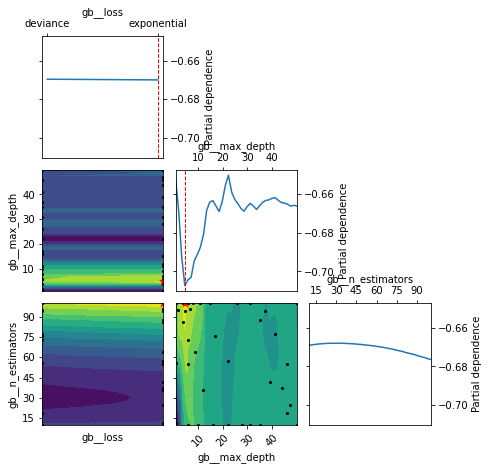

In [22]:
from skopt.plots import plot_objective

plot_objective(opt.optimizer_results_[0]);

In [24]:
opt.best_params_

OrderedDict([('gb__loss', 'exponential'),
             ('gb__max_depth', 5),
             ('gb__n_estimators', 100)])

#### [Plot Evaluations](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html#skopt.plots.plot_evaluations)
No método `plot_evaluations` a diagonal mostra histogramas dos pontos que foram amostrados para cada uma das dimensões do espaço de busca. 
No triângulo inferior é mostrado um gráfico de dispersão (scatter) bidimensional de todos os pontos no qual a ordem em que os pontos foram avaliados está codificada na cor de cada ponto. Cores mais escuras/roxas correspondem a amostras anteriores e cores mais claras/amarelas correspondem a amostras posteriores. A estrela em vermelho mostra a localização do mínimo encontrado pelo processo de otimização.


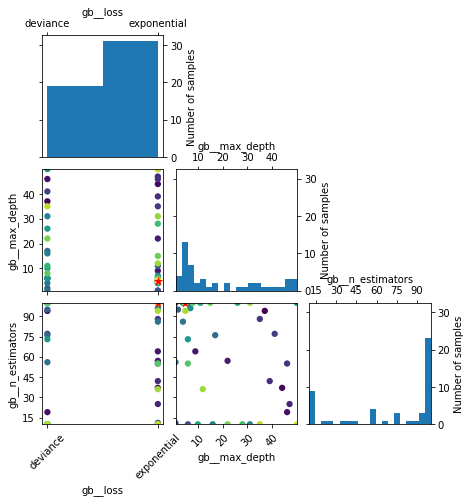

In [25]:
from skopt.plots import plot_evaluations

plot_evaluations(opt.optimizer_results_[0]);

Exemplos de uso desses gráficos: [link](https://scikit-optimize.github.io/stable/auto_examples/plots/visualizing-results.html#sphx-glr-auto-examples-plots-visualizing-results-py)

___
___
___

### Limitações:
- A principal limitação da otimização Bayesiana com Processos Gaussianos é a eficiência. À medida que a dimensionalidade aumenta, mais pontos precisam ser avaliados. Infelizmente, o custo da inferência exata no processo gaussiano escala como $O[n^3]$ onde n é o número de pontos de dados.
- Não é facilmente paralelizável como o GridSearch e o RandomSearch

### Resumo:

Queremos encontrar um valor ótimo de uma função que é super cara para avaliar. O que fazemos: avaliamos essa função algumas vezes e usamos um modelo substituto que se aproxima da função verdadeira. Neste caso, o modelo substituto será encontrado através de um processo gaussiano. Utilizamos os valores da média e da variância do processo gaussiano para descobrir onde será o próximo ponto a ser avaliado e para tomar essa decisão utilizamos algo que é chamado de função aquisitiva.

Dessa forma, gastamos um pouco mais de tempo selecionando os próximos hiperparâmetros mas fazemos menos chamadas na função objetivo. Na prática, o tempo gasto selecionando os próximos hiperparâmetros é muito menor quando comparado com o tempo gasto na função objetivo.

Sempre teremos um trade-off entre garantir a melhor combinação de hiperparâmetros e o custo de encontrá-la.

### Bibliografia e Aprofundamento
- [Explicação simples e didática](https://pt.quora.com/Como-funciona-a-otimiza%C3%A7%C3%A3o-bayesiana)
- [Comparação entre vários pacotes e métodos de otimização baysiana](https://medium.com/@gerbentempelman/comparing-hyperparameter-optimization-frameworks-in-python-a-conceptual-and-pragmatic-approach-24d9baa1cc69)
- [Um pouco mais matemático](https://medium.com/criteo-engineering/hyper-parameter-optimization-algorithms-2fe447525903)
- [Vídeo mostrando o funcionamento](https://gfycat.com/legalanyantelopegroundsquirrel)
- [Gifs mostrando a difetença de uma função de aquisição exploitative e explorative](https://www.andreaamico.eu/reinforcement-learning/2019/05/08/bayesian_opt.html)
- [O que é Otimização Bayesiana](https://machinelearningmastery.com/what-is-bayesian-optimization/)

Mais GIFS

<img src=https://www.andreaamico.eu/asset/images/2019-05-08/ei.gif width=700 text="https://www.andreaamico.eu/reinforcement-learning/2019/05/08/bayesian_opt.html">

___
___
___

#### Exercício

Aplique uma Otimização Bayesiana no seu projeto e análise os gráficos de otimização. 